In [3]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import pareto
from scipy.stats import lognorm
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
class herfindahl():
    '''
    Simulate herfindahl on Pareto and log-normal distributions
    
    ζ: tail index
    xm: minumum for Pareto distribution
    nSim: number of times of simulation
    N: number of firms
    μ, σ are the shape parameters for log-normal
    '''
    
    def __init__(self, ζ=1, xm=1, ):
        self.ζ = ζ
        self.xm = xm
        self.h = None
        
#     @property
#     def ζ(self):
#         return self.__ζ
    
#     @ζ.setter
#     def ζ(self, ζ):
#         self.__ζ = ζ
    
    def solve(self, lower=0.2, upper=10, plot=False, title=None):
        '''Solve μ and σ such that the lognormal matches the Pareto distribution'''
        ζ = self.ζ
        if ζ == 1:
            ζ += np.finfo(float).eps
        xm = self.xm
        μ = np.log(xm) + np.log(2) / ζ
        σ = np.sqrt(2 * (np.log(ζ * xm / (ζ - 1)) - μ))
        
        if plot:
            f = lambda x: pareto.pdf(x, b=self.ζ, loc=0, scale=self.xm)
            g = lambda x: lognorm.pdf(x, s=σ, scale=np.exp(μ))
            
            xd = np.linspace(1, upper, 100000)
            xd2 = np.linspace(lower, upper, 100000)
            plt.plot(xd, f(xd), label='Pareto')
            plt.plot(xd2, g(xd2), label='lognormal')
            plt.xlabel('x')
            plt.ylabel('probability')
            if title:
                plt.title(title)
            plt.legend()
            plt.show()
            print('μ=%1.5f, σ=%1.5f'%(μ, σ))
            
        return μ, σ
    
    def median_h(self, ζ=None, μ=None, σ=1, method='pareto', nSim=1000, N=1000000):
        
        if method != 'pareto' and method != 'lognormal':
            raise TypeError ('The distribution must be either Pareto or lognormal.')
            
        h = np.zeros(nSim)
        
        if method == 'pareto':
            
            if ζ == None:
                ζ = self.ζ
            for i in range(nSim):
                size = pareto.rvs(b=self.ζ, loc=0, scale=self.xm, size=N)
                h[i] = np.sqrt(np.sum(np.square(size / np.sum(size))))
        
        elif method == 'lognormal':
            
            if μ == None:
                if ζ:
                    self.ζ = ζ
                μ, σ = self.solve()
            
            for i in range(nSim):    
                size = lognorm.rvs(s=σ, scale=np.exp(μ), size=N)        
                h[i] = np.sqrt(np.sum(np.square(size/ np.sum(size))))
        
        self.h = np.median(h)
        return self.h    
    
    def s_GDP(self, h=None, s_π=0.12, method='pareto'):
        if h == None and self.h == None:
            h = self.median_h(method=method)
        elif h == None and self.h != None:
            h = self.h
        return h * s_π


To begin with, simulate the herfindhl for Pareto distribution. The formulas are from Gabaix (2011).

$$h = \big[\sum_{i=1}^{N} (\frac{S_{it}}{Y_t})^2\big]^{0.5} $$
$$Y_t = \sum_{i=1}^{N} S_{it} $$

Except for $\zeta=1$, also assume that $\zeta$ is 1.059 following Axtell(2001).

In [68]:
H = herfindahl()

for zeta in [1, 1.059, 1.5]:
    H.ζ = zeta
    print('If ζ is %1.3f' % zeta, end=',  ')
    print('then h is %1.2f%%' % (H.median_h()*100), end='')
    print(' and the corresponding σ_GDP is %1.2f%%.' % (H.s_GDP()*100))

If ζ is 1.000,  then h is 11.60% and the corresponding σ_GDP is 1.39%.
If ζ is 1.059,  then h is 8.42% and the corresponding σ_GDP is 1.01%.
If ζ is 1.500,  then h is 0.75% and the corresponding σ_GDP is 0.09%.


Then, if $\zeta$ is one, the herfindahl h is $11.6\%$. This is close to the simulation result, $12\%$ in Gabaix (2011).

While if $\zeta$ is $1.059\%$, the herfindahl is $8.42\%$ and the standard deviation of growth rate is $1.01\%$. 

Gabaix also indicates that the empirically measured aggregate standard deviation of growth rate is around $1\%$.

Generally, the result is compatible with Gabaix (2011).

#### Match the mean and median provided that the log-normal distribution is cut off under some $ \bar{x}$.
Given the Pareto distribution with tail index $\zeta > 1$, the density function is
\begin{equation}
    f_P(x)=
    \begin{cases}
      \frac{\zeta {\bar{x}}^{\zeta}}{x^{\zeta+1}}, & \text{if}\ x\geq \bar{x} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
Then, the corresponding mean and median are $\frac{\zeta \bar{x}}{\zeta-1}$ and $\bar{x} 2^{1/\zeta}$, respectively. The mean can be obtained by $\mathbb{E}(x)= \int x f_P(x) dx$ and the median is the root for $\frac{1}{2}=F_P(x)$ where $F_P(x)= 1-({\frac{x}{\bar{x}}})^{-\zeta}$ is the cumulative density function for $x \geq \bar{x}$.

If the log-normal distribution is $\ln(x) \sim \mathcal{N}(\mu, \,\sigma)$, then we can use the same approaches to find that its mean and median. The distribution for log-normal is
$$g(x) = \frac{1}{\sigma x \sqrt{2\pi}} \exp\{ {-\frac{(\ln{x-\mu})^2}{2\sigma^2}} \}.$$

Thus, from $\mathbb{E}(x)=\int g(x)dx$, the mean is $\exp(\mu + \frac{\sigma^2}{2})$. In addition, the CDF is $G(x) = \Phi(\frac{\ln(x)-\mu}{\sigma})$ where $\Phi(.)$ is the CDF for standard normrl. Then, using $\frac{1}{2} = G(x)$, we know that $\frac{\ln(x)-\mu}{\sigma}=0$ and so the median is $\exp(\mu)$.

Now, we can try to match the log-normal with Pareto distribution under Zipf's law. Since the first moment is infinite when $\zeta=1$ for Pareto distribution, let $\zeta$ be very close to one but not one. Following the assumption for simulation in (Gabaix, 2011), assume $\bar{x}=1$. Then, fixing the mean and median of Pareto distribution (or fixing $\zeta$ and $\bar{x}$), if the mean and median for log-normal distribution are equal to those of Pareto distribution, we have

\begin{align*}\label{eq:1}
\text{mean} \quad & \frac{\zeta \bar{x}}{\zeta-1} = \exp(\mu + \frac{\sigma^2}{2}) \\
\text{median} \quad & \bar{x} 2^{1/\zeta} = \exp(\mu) \\ 
\end{align*}

Solve the equation of median given $\zeta$ and $\bar{x}=1$, we have $\mu = \ln(2^{1/\zeta})$. Plug this into the mean equation, we can get $\sigma = (2 \ln(\frac{\zeta}{\zeta-1}) - \frac{2}{\zeta}\ln2)^{1/2}$.

##### Use the formula to sove $\mu$ and $\sigma$ numerically and plot the distribution.

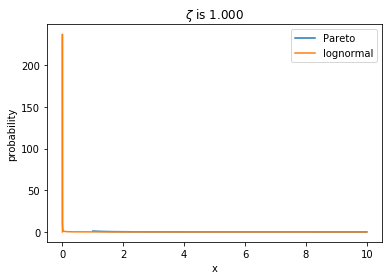

μ=0.69315, σ=8.40839


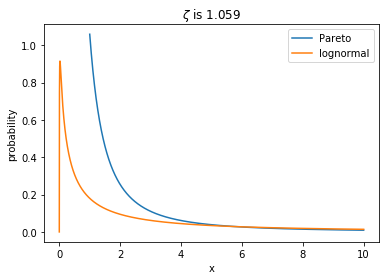

μ=0.65453, σ=2.11330


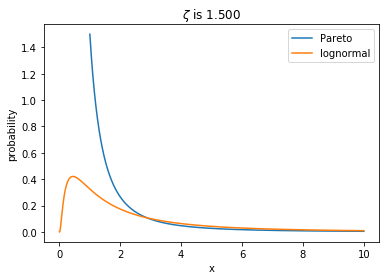

μ=0.46210, σ=1.12829


In [105]:
H = herfindahl()
for zeta in [1+np.finfo(float).eps, 1.059, 1.5]:
    H.ζ = zeta
    H.solve(lower=0, plot=True, title='$\zeta$ is %1.3f'%zeta)

The matched log-normal has the parameters $\mu=0.65453$ and $\sigma=2.11330$. Simulate the herfindahl for log-normal with these parameters.

In [106]:
for zeta in [1.059, 1.5]:
    H.median_h(ζ=zeta, method='lognormal')
    print('If ζ is %1.3f' %zeta, end=',  ')
    print('then h is %1.2f%% for matched log-normal' %(H.h*100), end='')
    print(' and the corresponding σ_GDP is %1.2f%%.' %(H.s_GDP()*100))

If ζ is 1.059,  then h is 0.85% for matched log-normal and the corresponding σ_GDP is 0.10%.
If ζ is 1.500,  then h is 0.19% for matched log-normal and the corresponding σ_GDP is 0.02%.


 ##### Conclusion
 For both $\zeta=1.059$ and $\zeta=1.5$, the volativity for GDP growth are too small and not in the same magnitude.
 
 $(\mu, \sigma)=(0.6545, 2.1133)$ are the shape parameters for matched log-normal under $\zeta$=1.059. In this case, the herfindahl is $0.85\%$ which is much smaller than $8.42\%$ of Pareto distribution. 
 
 When firm's growth rate is $12\%$, the deviation of growth rate $ \sigma_{GDP} = h\sigma $ is around $0.10\%$ for log-normal which is also higher than $1.01\%$ of Pareto when $\zeta=1.059$. Since the empirically measured macroeconomic fluctuation is around $1\%$, the log-normal distribution is not reasonable under this matching.

Some notes on the case that $\zeta$ is very close to one.

If $\zeta$ is one plus the smallest number in Python, then the mean is 

In [88]:
1/np.finfo(float).eps

4503599627370496.0

Use the parameters from matched log-normal to find the mean.

In [91]:
μ, σ = 0.69315, 8.40839
np.exp(μ) * np.exp(σ**2 / 2)

4503634786807620.0

The corresponging mean and variance are

In [92]:
print(np.exp(μ+σ**2/2))
print((np.exp(σ**2) - 1)*np.exp(2*μ + σ**2))

4503634786807632.0
1.0284666652696082e+62


The variance is much larger than the mean, so the coefficient in equation (6) might be very large.